In [166]:
import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt
import os

In [ ]:
cislo_pokusu = "5"
nazev_slozky = f"Pokus_cislo_{cislo_pokusu}"
nazev_souboru = f"{nazev_slozky}\\polohy_MC_{cislo_pokusu}.xyz"


pocet_castic = 500
teplota = 170                       # [K]
hmotnost_argonu = 39.948 * 1.66e-27 # [kg]

kb = 1.3806E-23                     # [J*K^-1]
epsilon = 119.8 * kb                # [J]
sigma = 3.41E-10                    # [m]

ro_molarni = 0.14287 * 10**3        #[mol/dm^3] * 10^3 = [mol/m^3]
avogadrova_konst =6.022E23
ro_ciselna = ro_molarni * avogadrova_konst
objem = pocet_castic / ro_ciselna

velikost_strany_boxu = (objem)**(1/3)
r_cut = 4*sigma
hustota = pocet_castic / objem

In [168]:
def precist_posledni_polohy(nazev_souboru, pocet_castic):
    with open(nazev_souboru, "r") as soubor:
        radky = soubor.readlines()[-(pocet_castic + 2):]

    posledni_pozice = []
    for radek in radky[2:]:
        castice = radek.split()
        if len(castice) == 4:
            x, y, z = map(float, castice[1:])
            posledni_pozice.append([x, y, z])
    return np.array(posledni_pozice)

### $ r_{abs} = |\vec{r_{1}} - \vec{r_{2}}| = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2} $

In [169]:
def vzdalenost_dvou_casic(poloha_castice_1, poloha_castice_2):
    summa = 0
    for souradnice_c1, souradnice_c2 in zip(poloha_castice_1, poloha_castice_2):
        delta = souradnice_c1 - souradnice_c2
        delta -= round(delta / velikost_strany_boxu) * velikost_strany_boxu
        
        summa += delta ** 2
    return summa

## LJ potencialni energie paru

### $ U_{r_{ij}} = 4 \epsilon \sum{[ (\frac {\sigma}{r_{abs}})^{12} - (\frac {\sigma}{r_{abs}})^{6} ]} $

In [170]:
def LJ_potencialni_energie_castice(ctvr_vzdal): # upravy pro ctvr_vzdal = asb_vzdal^2 
    if ctvr_vzdal > r_cut**2:
        U_paru = 0
    else:
        U_paru = 4 * epsilon *( (sigma**2/ctvr_vzdal)**6 - (sigma**2/ctvr_vzdal)**3 )
    return U_paru

## Celkova potencialni energie 

### $U_{total} = \sum_{i=1}^{N-1} \sum_{j=i+1}^{N} U_{r_{ij}}  $ 

In [171]:
def celkova_pot_en(polohy):
    U_tot = 0
    for i in range(pocet_castic-1):
        for j in range(i+1, pocet_castic):     
            ctvr_vzdal = vzdalenost_dvou_casic(polohy[i], polohy[j])
            U_paru = LJ_potencialni_energie_castice(ctvr_vzdal)
            U_tot += U_paru
    return U_tot

Nova poloha $\vec{r_{z}^{i}} [\sigma]$  
### $ \vec{r_{z}^{i}} = \vec{r_{i}^{j}} + \vec{u} (- u_{max},  u_{max}) $

In [172]:
def posunuti(stara_poloha, u_max = 10*sigma): 
    nova_poloha = stara_poloha + np.random.uniform(-u_max, u_max, 3)
    return nova_poloha % velikost_strany_boxu

####  2 Zmena $E_{pot}$ v celem systemu

$\Delta E = E_{nova} - E_{stara} \Rightarrow \Delta E \le 0 ...  \text{prijmame zmeny.}  $

$ \Delta E > 0: \text{prijimame zmeny polohy/hybosti s pravdepodobnosti } P = e^{-\Delta E / (k_B T)} $ kterou poravnavame s nahodnym cislem r, s rovnomernym rozlozenim $r \in [0,1] $

$r<P$ prijmame zmeny (t.z P je blizko 1), $r \ge P$ odmitame

In [173]:
def pravdepodobnostni_kriterium(delta_e):
    return True if delta_e <= 0 or np.random.rand() < np.exp(-delta_e / (kb * teplota)) else False

In [174]:
def energie_pot_zvol_cast(polohy, id_castice, pocet_castic):
    U_tot = 0
    for i in range (id_castice):
        ctvr_vzdal = vzdalenost_dvou_casic(polohy[i], polohy[id_castice])
        U_paru = LJ_potencialni_energie_castice(ctvr_vzdal)
        U_tot += U_paru        
    for j in range (id_castice+1, pocet_castic):
        ctvr_vzdal = vzdalenost_dvou_casic(polohy[j], polohy[id_castice])
        U_paru = LJ_potencialni_energie_castice(ctvr_vzdal)
        U_tot += U_paru
    return U_tot

In [175]:
def metropolis_krok(polohy):
    nove_polohy = deepcopy(polohy)
    id_nah_cast = np.random.randint(0, pocet_castic)
    nove_polohy[id_nah_cast] = posunuti(polohy[id_nah_cast])
    
    stara_pot_en = energie_pot_zvol_cast(polohy, id_nah_cast, pocet_castic)
    nova_e_pot = stara_pot_en = energie_pot_zvol_cast(polohy, id_nah_cast, pocet_castic)
    
    delta_e_pot = nova_e_pot - stara_pot_en
    prijmout_polohy = pravdepodobnostni_kriterium(delta_e_pot)
    
    if prijmout_polohy: return nove_polohy
    else:               return polohy

### Radialni distribucni funkce

pocitat prez pary a pak najit slupku do ktere to spadne
 

In [176]:
# def rad_distr_f(polohy, pocet_dilku):
#     r = np.linspace(0, 15e-10, pocet_dilku) # muzeme do 15 A, ale delame do r_cut
#     delta_r = r[1] - r[0]
#     g_r = np.zeros(pocet_dilku)
#     for vzdalenost in range(pocet_dilku-1):
#         pocet_castic_v_kruz = 0    
#         for i in range(pocet_castic-1):
#             for j in range(i+1, pocet_castic):  # pary
#                 abs_vzdal = vzdalenost_dvou_casic(polohy[i], polohy[j])
#                 if r[vzdalenost] <= abs_vzdal < r[vzdalenost + 1]:
#                     pocet_castic_v_kruz += 1
#         V_r= 4* np.pi * r[vzdalenost+1]**2 *delta_r
#         # hustota = (pocet_castic/objem_boxu) * V_r
#         g_r[vzdalenost] = (pocet_castic_v_kruz / V_r)/hustota
#     return g_r

In [177]:
def rad_distr_f(polohy, pocet_dilku):
    delta_r = 15E-10 / pocet_dilku
    n_castic_slupky = np.zeros(pocet_dilku)

    for i in range(pocet_castic - 1):
        for j in range(i + 1, pocet_castic):  
            abs_vzdal = np.sqrt(vzdalenost_dvou_casic(polohy[i], polohy[j]))
            index = int(abs_vzdal // delta_r)  
            if index < pocet_dilku:
                n_castic_slupky[index] += 1
    
    for i in range(len(n_castic_slupky)):
        V_r= 4* np.pi * (delta_r*(i+1))**2 *delta_r
        n_castic_slupky[i] = (n_castic_slupky[i]/V_r) / hustota /pocet_castic
    
    return n_castic_slupky

jak funguje a co znamena k cemu jsou?, produkcni faze

In [ ]:
def main():  
    polohy = precist_posledni_polohy(nazev_souboru, pocet_castic)
    
    rdf_kroky = 50
    pocet_dilku = 100
    rdf_vysledky = np.zeros(pocet_dilku)

    with open (f"{nazev_slozky}\\rdf_{cislo_pokusu}.txt", "w") as soubor_rdf:
        
        for _ in range(rdf_kroky, pocet_dilku):
            rdf_mezni = np.zeros(pocet_dilku)
            for _ in range(300):
                polohy = metropolis_krok(polohy)
            rdf_nove = rad_distr_f(polohy, pocet_dilku)
            # polohy = metropolis_krok(polohy)
            rdf_mezni += rdf_nove
            rdf_vysledky += rdf_mezni    
            
            for rdf in rdf_vysledky:
                soubor_rdf.write(f"{rdf} \n")
     
    return rdf_vysledky/rdf_kroky 

In [179]:
rdf_vysledky = main()

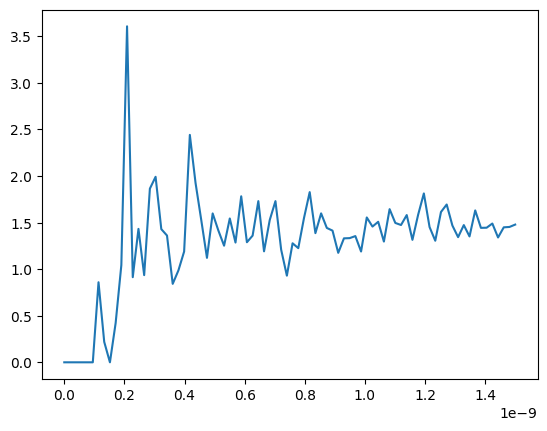

In [186]:
pocet_dilku = 80
x = np.linspace(0, 15e-10, len(rdf_vysledky))
plt.plot(x,rdf_vysledky)

In [181]:
with open (f"{nazev_slozky}\\vysledny_rdf_{cislo_pokusu}.txt", "w") as soubor_rdf:
    for rdf in rdf_vysledky:
        soubor_rdf.write(f"{rdf} \n")